In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger

c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Debuggin neural networks can be very difficult. Pytorch lightning provides a few tools to help with this.

Some useful ones (among others) that will be explored are the trainer flags:
 - fast_dev_run=True (this will not save checkpoints or log anything, in stead this will "touch" every part of your code from training to validation to test and just make sure it runs)
 - overfit_batch=int|float (this will take a single batch of your training data and train on it over and over in an attempt to overfit on it. If the model is not able to overfit on a single batch of data, then there is likely a problem with the model) set it to an iteger (e.g. 1) then it will use one batch. You can also set it to a float (e.g. 0.1) and it will use 10% of the data.
 - num_sanity_val_steps=int (this will run the validation loop on the first n batches of the validation set. This is useful to make sure that the validation loop is working as expected)

Set a breakpoint in the code using the following command:
    import pdb; pdb.set_trace()

In [2]:
def generate_cont_xor_data(num_points):
    """Generate a random XOR dataset with two continuous features."""
    x = torch.rand(num_points, 2)
    y = torch.logical_xor(x[:, 0] > 0.5, x[:, 1] > 0.5).long()
    return x, y

x, y = generate_cont_xor_data(1000)

class XORDataset(Dataset):
    def __init__(self, num_points):
        self.x, self.y = generate_cont_xor_data(num_points)

    def __getitem__(self, index):
        return {
            "point": self.x[index].float(),
            "label": self.y[index].float()
        }

    def __len__(self):
        return len(self.x)
    
train_loader = DataLoader(XORDataset(10000), batch_size=16)
test_loader = DataLoader(XORDataset(1000), batch_size=16)
val_loader = DataLoader(XORDataset(1000), batch_size=16)
for item in train_loader:
    points, labels = item["point"], item["label"]
    print(points.shape, labels.shape)
    break

torch.Size([16, 2]) torch.Size([16])


In [3]:
# lets create a simple model so we can see the debuggin process in action

class XORModel(pl.LightningModule):
    """This model predicts the XOR of two real inputs (continuous XOR)"""
    def __init__(self):
        super().__init__()
        # this is probably the most useful debugging feature
        self.example_input_array = torch.rand(1, 2)
        # the above line is optional but it allows you to see the dimensions in and out in the summary
        
        self.l1 = nn.Sequential(
            nn.Linear(2, 40),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.l2 = nn.Sequential(
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.regressor = nn.Sequential(
            nn.Linear(10, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.regressor(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch["point"], batch["label"]
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.unsqueeze(1))
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch["point"], batch["label"]
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.unsqueeze(1))
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch["point"], batch["label"]
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.unsqueeze(1))
        self.log('test_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-2)


In [4]:
# get a summary of the model
from lightning.pytorch.utilities.model_summary import ModelSummary
model = XORModel()
summary = ModelSummary(model, max_depth=-1)
summary

   | Name        | Type       | Params | In sizes | Out sizes
-------------------------------------------------------------------
0  | l1          | Sequential | 120    | [1, 2]   | [1, 40]  
1  | l1.0        | Linear     | 120    | [1, 2]   | [1, 40]  
2  | l1.1        | ReLU       | 0      | [1, 40]  | [1, 40]  
3  | l1.2        | Dropout    | 0      | [1, 40]  | [1, 40]  
4  | l2          | Sequential | 410    | [1, 40]  | [1, 10]  
5  | l2.0        | Linear     | 410    | [1, 40]  | [1, 10]  
6  | l2.1        | ReLU       | 0      | [1, 10]  | [1, 10]  
7  | l2.2        | Dropout    | 0      | [1, 10]  | [1, 10]  
8  | regressor   | Sequential | 11     | [1, 10]  | [1, 1]   
9  | regressor.0 | Linear     | 11     | [1, 10]  | [1, 1]   
10 | regressor.1 | Sigmoid    | 0      | [1, 1]   | [1, 1]   
-------------------------------------------------------------------
541       Trainable params
0         Non-trainable params
541       Total params
0.002     Total estimated model params 

In [5]:
trainer = pl.Trainer(fast_dev_run=True)
# this will test everything and make sure the model does not break at a later validation point
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.s

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [6]:
# overfit on batch - what should happen here is that the training loss should go to 0 and the validation loss should go up
train_over = pl.Trainer(overfit_batches=1, max_epochs=200)
train_over.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | l1        | Sequential | 120    | [1, 2]   | [1, 40]  
1 | l2        | Sequential | 410    | [1, 40]  | [1, 10]  
2 | regressor | Sequential | 11     | [1, 10]  | [1, 1]   
----------------------------------------------------------------
541       Trainable params
0         Non-trainable params
541       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [7]:
# now we are good to go, we can train
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "./level_4_debug_bottlenecks_viz.ipynb"
logger = WandbLogger(name="cont_xor_2", project="debugging", log_model="all")

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode="min"
)

trainer = pl.Trainer(max_epochs=30,  logger=logger, callbacks=[early_stop_callback])
trainer.fit(model, train_loader, val_loader)

wandb: Currently logged in as: benjaminvh1997. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | l1        | Sequential | 120    | [1, 2]   | [1, 40]  
1 | l2        | Sequential | 410    | [1, 40]  | [1, 10]  
2 | regressor | Sequential | 11     | [1, 10]  | [1, 1]   
----------------------------------------------------------------
541       Trainable params
0         Non-trainable params
541       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.095


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.080


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.072


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.071


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.071. Signaling Trainer to stop.


In [8]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.08301035314798355    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08301035314798355}]

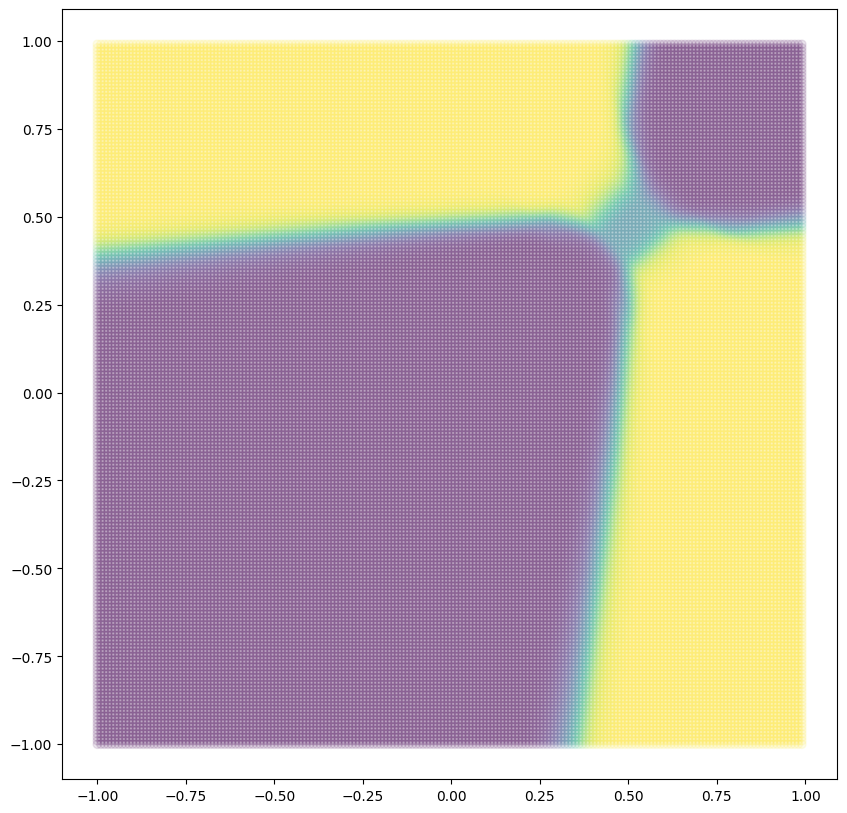

In [9]:
# plot the decision boundary for the model
import numpy as np
import matplotlib.pyplot as plt

xx, yy = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))

points = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
points.shape

model.eval()
preds = model(points)

fig = plt.figure(figsize=(10, 10))
plt.scatter(xx.ravel(), yy.ravel(), c=preds.detach().numpy().ravel(), alpha=0.1)



In [10]:
# find bottlenecks in training
# another of the trainer's useful tricks is that it can profile a model to find bottlenecks in training

prof_trainer = pl.Trainer(profiler="simple", callbacks=[early_stop_callback])
prof_trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\lightning\pytorch\loops\utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | l1        | Sequential | 120    | [1, 2]   | [1, 40]  
1 | l2        | Sequential | 410    | [1, 40]  | [1, 10]  
2 | regressor | Sequential | 11     | [1, 10]  | [1, 1]   
----------------------------------------------------------------
541       Trainable params
0         Non-trainable params
541       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 11 records. Best score: 0.071. Signaling Trainer to stop.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                

In [11]:
# for the XOR model this is not very useful since it is so simple, but for more complex models
# this can help isolate where you should be looking to improve performance

# can also use an advance profiler via:
# from lightning.pytorch.profilers import AdvancedProfiler
#
# profiler = AdvancedProfiler(dirpath=".", filename="perf_logs") # stream to file
# trainer = Trainer(profiler=profiler)

In [15]:
# measure accelerator usage
# this is best used with just a few iterations as it is quite a bit of overhead
from lightning.pytorch.callbacks import DeviceStatsMonitor # requires a logger

train_stats = pl.Trainer(callbacks=[DeviceStatsMonitor()], logger=logger, max_epochs=3)
train_stats.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory .\debugging\zpd573ml\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | l1        | Sequential | 120    | [1, 2]   | [1, 40]  
1 | l2        | Sequential | 410    | [1, 40]  | [1, 10]  
2 | regressor | Sequential | 11     | [1, 10]  | [1, 1]   
----------------------------------------------------------------
541       Trainable params
0         Non-trainable params
541       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benja\Documents\Code\learning\pytorch-lightning\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
